# A template for experiments

I'm trying to develop a pipeline we can use for experiments on the NEH data: a template we can use for selecting data, training a model, and finally evaluating results. But this is by no means set in stone yet; it's a draft we can discuss and adjust.

For a first test, let's consider the problem of author gender. We know our data model of gender is imperfect (limited for the most part to m/f), and we don't imagine a predictive model trained on this boundary will tell us very much about gender directly; it's almost certainly, to some degree, a proxy for genre. But it's a tricky boundary to model and thus a good place to start. We're in no danger of getting 100% accuracy!

Our ultimate goal in this experiment, and other experiments based on this template, is to figure out:

1. What kinds of *historical questions* are really distorted by the errors in digital libraries? Our working hypothesis is that certain boundaries (like genre and date) are likely to be more sensitive than others (like e.g. gender), because the errors are in practice not distributed randomly.

2. What kinds of *errors* are most likely to produce distortion? I'm acting on the hypothesis (or hunch) that paratext is at least as big a problem as the better-studied problem of OCR error. For instance, the paratext in works of fiction is often from a different genre, and composed at a different time, than the original work. So it's very likely to distort conclusions.

### Imports

In [220]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

### Volume metadata

This metadata file is in the GitHub repo. It has one row for each clean volume. 

Not all of these volumes have been trimmed and chunked; we will rely on the Box folders for a list of the chunks actually available to model. But then we will use this list in order to get features like genre, gender, and date.

In [74]:
volmeta = pd.read_csv('../metadata/updatedvolumemetadata.tsv', sep = '\t')

In [75]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


Here's a function we can use to generate a simpler genre column for modeling the biography / fiction boundary.

In [76]:
def simplify_genre(genrestring):
    genres = [x.strip() for x in genrestring.split('|')]
    if 'bio' in genres:
        return 'bio'
    elif 'fic' in genres:
        return 'fic'
    else:
        print('anomaly', genrestring)
        return float('nan')

volmeta['simplegenre'] = volmeta['genre'].apply(simplify_genre)

anomaly dutch


### Works we have actually trimmed and chunked so far

The Box folders ```cleannarratives``` and ```dirtynarratives``` store processed texts.

The ```cleannarratives``` folder consists of Gutenberg texts, manually trimmed and then automatically chunked to contain ~80,000 characters each.

The ```dirtynarratives``` folder contains Hathi texts that have *not* been trimmed. The only clean-up done on these so far is that running headers have been removed. They've also been chunked to contain ~80,000 characters each, but the boundaries are not aligned with ```cleannarratives.```

Note that the number of files will not be the same in these two folders, and the number of chunks for each volume will not be the same. They are chunked independently.

In [77]:
cleanfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/cleannarratives/')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('/Users/tunder/Box Sync/NEHproject/dirtynarratives/')
               if x.endswith('.txt')]

In [78]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


What is actually in these data objects?

In [79]:
cleanfiles[0]

'36965_3.txt'

How many *volumes* have we trimmed and chunked so far?

In [80]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [81]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


Let's create a dataframe with just the volumes we're actually using.

In [82]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 25)

### Balancing the distribution of classes across time

Language change is very easy to model, so if you try to model the boundary between two categories that happen to be distributed differently across time (in your collection), you're very likely to get a model of language change. That's a problem if you want to study the categorical difference in itself, separated from confounding issues of chronology that might just be selection bias.

Here we're distinguishing books written by men from those written by women. And although we don't really care about the model in its own right (since we're interested in the consequences of OCR distortion), it's still important to know what we're modeling, because OCR distortion could have *different* effects on different kinds of boundaries (e.g. chronological or demographic). 

So we need to be careful to balance the classes across time. At a minimum, we should require the median date for both categories to be roughly the same. A more ambitious approach would match the full distribution. But for right now let's keep it simple.

Also, in order to keep things simple, let's select both classes to be the same size. So we'll match the size of the smaller class.

In [83]:
indexes_f = ourtitles.loc[ourtitles.authgender == 'f', : ].index.tolist()
indexes_m = ourtitles.loc[ourtitles.authgender == 'm', : ].index.tolist()
print('The smaller class has ', len(indexes_f), ' volumes.')

The smaller class has  139  volumes.


The following function selects a matching number of volumes while keeping the median date similar in both categories.

In [84]:
def match_medians(smaller_indexes, larger_indexes, metadata):
    '''
    smaller_indexes = indexes of metadata for the smaller class
    larger_indexes = indexes of metadata for the larger class
    '''
    selected_from_large = []
    smaller_median = np.median(metadata.loc[smaller_indexes, 'latestcomp'])
    
    largerdf = metadata.loc[larger_indexes, : ]
    above_median = largerdf.loc[largerdf['latestcomp'] >= smaller_median, : ].index.tolist()
    below_median = largerdf.loc[largerdf['latestcomp'] <= smaller_median, : ].index.tolist()
    
    for i in range(len(smaller_indexes)):
        if len(selected_from_large) > 0:
            larger_median = np.median(metadata.loc[selected_from_large, 'latestcomp'])
        else:
            larger_median = smaller_median
        
        if larger_median >= smaller_median and len(below_median) > 0:
            selected = random.sample(below_median, 1)[0]
            below_median.pop(below_median.index(selected))
            selected_from_large.append(selected)
        elif larger_median <= smaller_median and len(above_median) > 0:
            selected = random.sample(above_median, 1)[0]
            above_median.pop(above_median.index(selected))
            selected_from_large.append(selected)
        else:
            # we have no more items that won't distort the median
            break

    return selected_from_large, smaller_median, larger_median

selected_m, median_f, median_m = match_medians(indexes_f, indexes_m, ourtitles)  

In [85]:
print(median_f, median_m, len(selected_m))

1890.0 1889.5 139


In [86]:
all_selected_vols = indexes_f + selected_m
len(all_selected_vols)

278

We've gathered the actual indexes of rows in ```ourtitles.``` Now let's convert those to Gutenberg indexes (or other clean-volume identifiers, in cases where volumes are drawn from ECCO, etc.)

In [87]:
selected_gbindexes = ourtitles.loc[all_selected_vols, 'gbindex']

### Merging chunk and volume

So far we've been operating at the volume level. But we will need chunk-level metadata in order to actually model the files.

Let's create dataframes that have a row for each chunk and merge those dataframes with the information in volmeta.

In [88]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [89]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.shape

(2489, 26)

In [90]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.shape

(2610, 26)

Now we select the subsets of those dataframes with Gutenberg indexes that were selected by the match_medians function.

In [91]:
cleanmodelmeta = cleanmeta.loc[cleanmeta['gbindex'].isin(selected_gbindexes), : ]
cleanmodelmeta.shape

(1563, 26)

In [92]:
dirtymodelmeta = dirtymeta.loc[dirtymeta['gbindex'].isin(selected_gbindexes), : ]
dirtymodelmeta.shape

(1624, 26)

### Term-document matrices for clean and dirty narratives 


In [93]:
clean_rootdir = '/Users/tunder/Box Sync/NEHproject/cleannarratives/'

clean_paths = []

for chunk_id in cleanmodelmeta['chunkid']:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')
    

In [94]:
clean_model_chunk_ids = cleanmodelmeta['chunkid']

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealous,zealously,zenith,zest,zigzag,zone,æsthetic
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_2,0,2,0,0,2,0,2,1,2,0,...,0,0,1,0,0,0,0,0,0,0
36965_0,0,0,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
36965_4,0,2,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
dirty_rootdir = '/Users/tunder/Box Sync/NEHproject/dirtynarratives/'

dirty_paths = []

for chunk_id in dirtymodelmeta['chunkid']:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymodelmeta['chunkid']
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſwered,ſwore,ſº,ﬁnd,ﬁrst
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36965_4,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Turn wordcounts into normalized frequencies

In [96]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [97]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [98]:
dirty_freqs.head()

,00,000,01,10,100,101,102,103,104,105,...,ſuſpect,ſuſpected,ſuſpicion,ſwear,ſweet,ſwered,ſwore,ſº,ﬁnd,ﬁrst
chunkid,,,,,,,,,,,,,,,,,,,,,
36965_3,0.000000,0.0,0.0,0.000074,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_2,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_0,0.000000,0.0,0.0,0.000000,0.000073,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36965_4,0.000216,0.0,0.0,0.000072,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice the eighteenth-century long S's!

### Separate train & validation from final test set

We will optimize our model by cross-validating on 3/4 of the data, and finally test on a held-out 1/4. The same volumes should be held out for both clean and dirty data. Note that we select *by author* to avoid leakage across this boundary.

In [100]:
selected_authors = list(set(volmeta.loc[volmeta['gbindex'].isin(selected_gbindexes), 'author']))
random.shuffle(selected_authors)
threequarters = int(len(selected_authors) * .75)
trainauthors = selected_authors[0 : threequarters]
testauthors = selected_authors[threequarters: ]

cleantrain = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(trainauthors), : ]
cleantest = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(testauthors), : ]
cleantrain_freqs = clean_freqs.loc[cleantrain.chunkid]
cleantest_freqs = clean_freqs.loc[cleantest.chunkid]

dirtytrain = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(trainauthors), : ]
dirtytest = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(testauthors), : ]
dirtytrain_freqs = dirty_freqs.loc[dirtytrain.chunkid]
dirtytest_freqs = dirty_freqs.loc[dirtytest.chunkid]

In [101]:
print('Clean training set: ', cleantrain.shape)
print('Clean test set: ', cleantest.shape)
print('Hathi training set: ', dirtytrain.shape)
print('Hathi testing set: ', dirtytest.shape)

Clean training set:  (1177, 26)
Clean test set:  (386, 26)
Hathi training set:  (1231, 26)
Hathi testing set:  (393, 26)


Let's put our master modelmeta frames in the right order to use later.

In [173]:
dirtymodelmeta.set_index('chunkid', inplace = True)
print(dirtymodelmeta.shape)
dirty_ids_order = np.append(list(dirtytrain.chunkid), list(dirtytest.chunkid))
dirtymodelmeta = dirtymodelmeta.loc[dirty_ids_order, : ]
dirtymodelmeta.reset_index(inplace = True)
dirtymodelmeta.shape

(1624, 25)


(1624, 26)

In [174]:
cleanmodelmeta.set_index('chunkid', inplace = True)
print(cleanmodelmeta.shape)
clean_ids_order = np.append(list(cleantrain.chunkid), list(cleantest.chunkid))
cleanmodelmeta = cleanmodelmeta.loc[clean_ids_order, : ]
cleanmodelmeta.reset_index(inplace = True)
cleanmodelmeta.shape

(1563, 25)


(1563, 26)

### Let's produce a model for the clean counts

We're going to do a grid search for the best model. The outer loop will select the number of features. The inner loop will select the regularization constant.

In selecting the top *n* features, we will always select the *n* with top *document* frequency.

We will do the cross-validation only on the training set. This means in effect that there are lots of different "validation sets" inside the training set. But the test set itself is a separate issue.

In [224]:
def get_doc_freqs(X, y):
    return np.count_nonzero(X, axis=0)
        

In [253]:
resultarray = []

featureoptions = [2000, 2500, 3000, 3500, 3800, 4000, 4200, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
c_options = [1000000, 100000, 10000, 3000, 1000, 500, 100, 10, 1, .1]

for featurecount in featureoptions:
    docfreqs = []
    for col in cleantrain_freqs.columns:
        docfreqs.append((sum(cleantrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order
    
    model_features = cleantrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fkb', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])    
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features,
                                    y = cleantrain['authgender'], 
                                    groups = cleantrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)
     

2000 1000000 0.717094017094017
2000 100000 0.7179414747211357
2000 10000 0.7213313052296103
2000 3000 0.7289729103288425
2000 1000 0.7298348544111256
2000 500 0.725583079820368
2000 100 0.724728378965667
2000 10 0.7238736781109663
2000 1 0.730675068810662
2000 0.1 0.733253657829929
2500 1000000 0.7281326959293061
2500 100000 0.7298348544111256
2500 10000 0.7357887874837028
2500 3000 0.7468274663189918
2500 1000 0.7468274663189918
2500 500 0.7459944951470375
2500 100 0.7451397942923367
2500 10 0.7468347095465739
2500 1 0.7451180646095901
2500 0.1 0.7535926408807765
3000 1000000 0.7272707518470231
3000 100000 0.7281254527017239
3000 10000 0.7298203679559612
3000 3000 0.7502245400550486
3000 1000 0.7493698392003477
3000 500 0.7468129798638273
3000 100 0.7468202230914095
3000 10 0.7468347095465739
3000 1 0.7510792409097494
3000 0.1 0.7536143705635231
3500 1000000 0.7298276111835434
3500 100000 0.730675068810662
3500 10000 0.7366290018832391
3500 3000 0.7459727654642909
3500 1000 0.75022454

#### visualize the grid search

This can be a good way to check that you've really covered the space and "surrounded" the optimum value on all sides.

In [254]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   # I'm doing this because otherwise
                                                    # fine details at top of range can be hard to see.

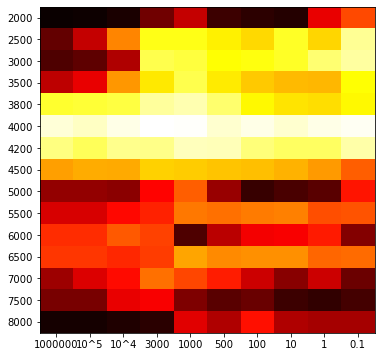

In [255]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[1] = '10^6'
thexlabels[1] = '10^5'
thexlabels[2] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [261]:
docfreqs = []
for col in clean_wordcounts.columns:
    docfreqs.append((sum(clean_wordcounts[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-4000: ]] #because sorted ascending

train_features = cleantrain_freqs.loc[ : , features]  
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = 3000, max_iter = 2000)
cleantrain_probabilities = cross_val_predict(bestmodel, train_features, cleantrain['authgender'], 
                                     groups = cleantrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = 3000, max_iter = 2000)
bestmodel.fit(train_features, cleantrain['authgender'])

test_features = cleantest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

cleantest_predictions = bestmodel.predict(test_features)
cleantest_probabilities = bestmodel.predict_proba(test_features)


In [262]:
sum(cleantest_predictions == cleantest['authgender']) / len(cleantest['authgender'])

0.8031088082901554

### Now a model for the dirty counts

In [263]:
resultarray = []

featureoptions = [3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000]
c_options = [1000000, 100000, 10000, 3000, 1000, 500, 100, 10, 1, .1]

for featurecount in featureoptions:
    docfreqs = []
    for col in dirtytrain_freqs.columns:
        docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending
    
    model_features = dirtytrain_freqs.loc[ : , features]
    
    resultrow = []
    
    for c_param in c_options:
        logreg = LogisticRegression(C = c_param, max_iter = 2000)
        scaler = StandardScaler()
        # feature_selector = SelectKBest(get_doc_freqs, k = featurecount)
        pipe = Pipeline([
            # ('fs', feature_selector),
            ('sc', scaler),
            ('lr', logreg)
        ])
        grouper = GroupKFold(n_splits = 10)
        cv_results = cross_validate(estimator = pipe, 
                                    X = model_features, 
                                    y = dirtytrain['authgender'], 
                                    groups = dirtytrain['author'], 
                                    cv = grouper)
        mean_score = np.mean(cv_results['test_score'])
        print(featurecount, c_param, mean_score)
        resultrow.append(mean_score)
    
    resultarray.append(resultrow)
    

3500 1000000 0.7334740297429414
3500 100000 0.7342870378730227
3500 10000 0.7383455220062511
3500 3000 0.7448629150490342
3500 1000 0.7464758182748407
3500 500 0.7424038986555915
3500 100 0.7448429230458353
3500 10 0.7432234633028509
3500 1 0.7464623827888199
3500 0.1 0.7481082835682932
4000 1000000 0.7309620237926334
4000 100000 0.7301490156625521
4000 10000 0.7309554672754554
4000 3000 0.7342010507624906
4000 1000 0.7390658790247342
4000 500 0.7390725430258003
4000 100 0.7382660914128972
4000 10 0.7390725430258005
4000 1 0.7423246830300139
4000 0.1 0.7382727554139634
4500 1000000 0.7415443500019346
4500 100000 0.742357358132016
4500 10000 0.7447832694879037
4500 3000 0.7455963851018732
4500 1000 0.7456162696211838
4500 500 0.74562938265554
4500 100 0.7431770302631635
4500 10 0.744796490006148
4500 1 0.7447899334889698
4500 0.1 0.7472488423985245
5000 1000000 0.746362852708379
5000 100000 0.7455365165761652
5000 10000 0.7447300649632622
5000 3000 0.7496017721943481
5000 1000 0.7479954

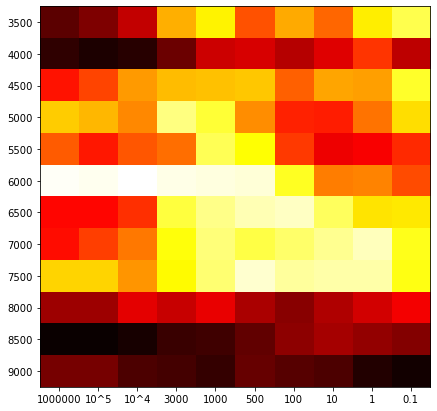

In [264]:
resultarray = np.array(resultarray)
thearrayshape = resultarray.shape
resarray = rankdata(resultarray).reshape(thearrayshape)   # I'm doing this because otherwise
                                                    # fine details at top of range can be hard to see.
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(resarray, cmap='hot', aspect = 'auto')
plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
thexlabels = [str(x) for x in c_options]
thexlabels[1] = '10^6'
thexlabels[1] = '10^5'
thexlabels[2] = '10^4'
plt.xticks(ticks = [x for x in range(len(c_options))], labels = thexlabels)
plt.show()

In [265]:
docfreqs = []
for col in dirtytrain_freqs.columns:
    docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
docfreqs.sort()
features = [x[1] for x in docfreqs[-6000 : ]]

train_features = dirtytrain_freqs.loc[ : , features]
    
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

bestmodel = LogisticRegression(C = 10000, max_iter = 2000)
dirtytrain_probabilities = cross_val_predict(bestmodel, train_features, dirtytrain['authgender'], 
                                     groups = dirtytrain['author'], cv = grouper,
                                    method = 'predict_proba')

## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

bestmodel = LogisticRegression(C = 10000, max_iter = 2000)
bestmodel.fit(train_features, dirtytrain['authgender'])

test_features = dirtytest_freqs.loc[ : , features] 
test_features = scaler.transform(test_features)    # Note this is the same scaler we fit
                                                # to train features; we DON'T fit a new one to the
                                                # test features. We deliberately blind ourselves to that
                                                # information.

dirtytest_predictions = bestmodel.predict(test_features)
dirtytest_probabilities = bestmodel.predict_proba(test_features)

In [266]:
sum(dirtytest_predictions == dirtytest['authgender']) / len(dirtytest['authgender'])

0.7786259541984732

So, looking both at the cross-validation and at the held-out test set, it appears that we get *slightly* worse accuracy with dirty data.

### The actual fun stuff: what creates the error?

I've saved the prediction probabilities from cross-validation on the training set (and from prediction on test), so that we can measure error for each chunk and try to diagnose the sources of error.

Our strategy here involves three measurements.

1. The "divergence from clean": how much does prediction error on a dirty chunk exceed (or fall below) the average error for clean chunks of this volume. Note that we cannot create a chunk-to-chunk mapping, since Hathi has not been trimmed.

2. The "worderrors" for the chunk: how many words in the Hathi chunk were not found *either* in the Gutenberg text or in a simple dictionary of 10,000 common English words? This is not exactly the same as word-error-rate, but it's a close approximation that we can use for the moment.

3. The "passagefails" for the chunk. What fraction of 20-character segments in the Hathi chunk could be found with fuzzy matching in (the whole) Gutenberg volume. We accepted difflib similarity scores of > 0.78 as a a match. This is **in effect** a measurement of the amount of text in the chunk that is substantially *different from* the Gutenberg text, because it's a table of contents, or introduction, or notes -- or a different translation!

The question we're trying to answer: does accuracy fall mostly because of OCR errors, or because of paratext? As you'll see, it's difficult to answer with these corpora. This evidence casts some light, but we will also need more experiments with multiple corpora.

We start by constructing vectors for real y and predicted $\widehat{y}$ — for both models.

In [295]:
dirty_y = dirtymodelmeta['authgender'].map({'f': 1, 'm': 0})  # we already put this in train-test order
                                                            # so it will match the next line
dirty_probabilities = np.append(dirtytrain_probabilities[ : , 0], dirtytest_probabilities[ : , 0])

We can reason about two kinds of error. 

Directional error: did this chunk appear more negative or positive than it was in the real y vector.

Absolute error: how far was this chunk from the real value in either direction.

In [296]:
dirty_error = dirty_y - dirty_probabilities
dirty_absolute_error = np.abs(dirty_error)

Repeat the above steps for the clean model.

In [297]:
clean_y = cleanmodelmeta['authgender'].map({'f': 1, 'm': 0})

clean_probabilities = np.append(cleantrain_probabilities[ : , 0], cleantest_probabilities[ : , 0])

In [298]:
clean_error = clean_y - clean_probabilities
clean_absolute_error = np.abs(clean_error)

#### Create mean values for clean volumes

We create a dataframe and then groupby / average on Gutenberg indexes.

In [304]:
clean_gbi = [get_gbindex(x) for x in cleanmodelmeta['chunkid']]
clean_df = pd.DataFrame({'chunkid': cleanmodelmeta['chunkid'], 'gbindex': clean_gbi,
                         'clean_error': clean_error, 'clean_abs_error': clean_absolute_error})

In [305]:
meandf = clean_df.groupby('gbindex').mean()

In [306]:
meandf.sample(10)

,clean_error,clean_abs_error
gbindex,,
39782,-0.039216,0.039216
34732,-0.000338,0.000338
50698,-0.533571,0.533571
27223,0.000028,0.000028
DefoDLSfic,-0.128360,0.128360
52240,0.132031,0.132031
43358,0.170363,0.170363
37046,-0.000827,0.000827
51103,0.030277,0.030277


In [330]:
dirty_gbi = [get_gbindex(x) for x in dirtymodelmeta['chunkid']]
dirty_df = pd.DataFrame({'chunkid': list(dirtymodelmeta['chunkid']), 'gbindex': dirty_gbi,
                         'dirty_error': dirty_error, 'dirty_abs_error': dirty_absolute_error})

In [331]:
dirty_df.sample(5)

,chunkid,gbindex,dirty_error,dirty_abs_error
449,31579_1,31579,-1.494654e-06,1.494654e-06
1181,36277_4,36277,-8.768491e-01,8.768491e-01
376,32642_1,32642,-4.820049e-04,4.820049e-04
1406,49154_2,49154,-6.376934e-09,6.376934e-09
33,amory.01_10,amory.01,-9.991067e-01,9.991067e-01


In [332]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex')
dirty_df['error_divergence'] = dirty_df['dirty_error'] - dirty_df['clean_error']
dirty_df['divergence_of_abs_error'] = dirty_df['dirty_abs_error'] - dirty_df['clean_abs_error']
dirty_df.sample(10)

,chunkid,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
352,40919_2,40919,-1.121937e-03,1.121937e-03,-5.572451e-04,5.572451e-04,-5.646914e-04,5.646914e-04
282,33609_8,33609,-1.562672e-01,1.562672e-01,-1.443196e-01,1.443196e-01,-1.194759e-02,1.194759e-02
1401,49154_5,49154,-2.181895e-01,2.181895e-01,-1.994395e-06,1.994395e-06,-2.181876e-01,2.181876e-01
1211,34263_1,34263,-7.892935e-05,7.892935e-05,-2.545191e-01,2.545191e-01,2.544402e-01,-2.544402e-01
200,34667_0,34667,-3.721030e-10,3.721030e-10,-6.780630e-08,6.780630e-08,6.743420e-08,-6.743420e-08
1509,63337_2,63337,1.274361e-03,1.274361e-03,4.424414e-01,4.424414e-01,-4.411670e-01,-4.411670e-01
162,38049_5,38049,1.023892e-11,1.023892e-11,3.280943e-09,3.280943e-09,-3.270704e-09,-3.270704e-09
1445,45206_7,45206,-2.715326e-01,2.715326e-01,-1.464117e-01,1.464117e-01,-1.251209e-01,1.251209e-01
680,54218_0,54218,8.952985e-06,8.952985e-06,7.142971e-02,7.142971e-02,-7.142076e-02,-7.142076e-02
990,31835_2,31835,5.716124e-05,5.716124e-05,1.661478e-03,1.661478e-03,-1.604317e-03,-1.604317e-03


In [337]:
# error0 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrors.tsv', sep = '\t')
#error1 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs1.tsv', sep = '\t')
#error2 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs2.tsv', sep = '\t')
#error3 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs3.tsv', sep = '\t')
#error4 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs4.tsv', sep = '\t')
#error5 = pd.read_csv('/Users/tunder/work/gh_align/hathichunkerrs5.tsv', sep = '\t')
#chunkerrors = pd.concat([error0, error1, error2, error3, error4, error5], ignore_index = True)

In [339]:
#chunkerrors.drop_duplicates(inplace = True)
#print(chunkerrors.shape)
#chunkerrors.to_csv('../metadata/hathi_chunk_errors.tsv', sep = '\t', index = False)
chunkerrors = pd.read_csv('../metadata/hathi_chunk_errors.tsv', sep = '\t')

In [340]:
chunkerrors.head()

,chunkid,passagefails,worderrors
0,36958_0,0.02087,0.02500
1,36958_1,0.02158,0.02177
2,36958_2,0.02039,0.02114
3,36958_3,0.02637,0.02103
4,49154_0,0.16478,0.01539


In [341]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid', how = 'left')
chunkerrors.head()

,chunkid,passagefails,worderrors,gbindex,dirty_error,dirty_abs_error,clean_error,clean_abs_error,error_divergence,divergence_of_abs_error
0,36958_0,0.02087,0.02500,36958,-3.389505e-06,3.389505e-06,-0.000759,0.000759,0.000755,-0.000755
1,36958_1,0.02158,0.02177,36958,-5.237897e-07,5.237897e-07,-0.000759,0.000759,0.000758,-0.000758
2,36958_2,0.02039,0.02114,36958,-5.590057e-05,5.590057e-05,-0.000759,0.000759,0.000703,-0.000703
3,36958_3,0.02637,0.02103,36958,-2.825321e-04,2.825321e-04,-0.000759,0.000759,0.000476,-0.000476
4,49154_0,0.16478,0.01539,49154,-4.653712e-06,4.653712e-06,-0.000002,0.000002,-0.000003,0.000003


In [349]:
pearsonr(chunkerrors['error_divergence'], chunkerrors['divergence_of_abs_error'])

(-0.08661333109432243, 0.00047530451176408295)

In [342]:
chunkerrors.shape

(2610, 10)

In [343]:
chunkerrors=chunkerrors.dropna()
chunkerrors.shape

(1624, 10)

In [350]:
pearsonr(chunkerrors['passagefails'], chunkerrors['error_divergence'])

(-0.00268935407583819, 0.9137619159860629)

In [351]:
pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_error'])

(0.08875858123278027, 0.0003420361165436282)

In [352]:
pearsonr(chunkerrors['worderrors'], chunkerrors['error_divergence'])

(-0.05304554045242785, 0.03255449695433055)

In [353]:
pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_error'])

(0.08099315781022871, 0.001087748457765953)

What we see here is that the direction of the error has no correlation with paratext. But it does correlate negatively, and significantly, with OCR error. Greater OCR error consistently made writers seem more masculine. (If I haven't gotten my arithmetic reversed.)

When we examine the divergence of absolute error (ignoring the direction), there's correlation in both cases. Paratext did significantly increase the absolute *amount* of error, and in fact did so more dramatically than OCR.

We can also reason about the absolute value of the difference between clean and dirty. In other words, we could decide not to care whether error was increased or decreased, and instead care only about how *different* the amount of error is.

In [355]:
pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['error_divergence']))

(0.13237078740524869, 8.609634515224656e-08)

That won't change if we substitute ```divergence_of_abs_error```.

Finally, we want to think about the correlation of our predictors.

In [291]:
pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors'])

(0.507774472802493, 3.684100007217292e-107)

**NOTE**: That's a very high correlation. Our predictve variables are extremely collinear.

## Interpretation

In [357]:
y = chunkerrors['divergence_of_abs_error']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_error   R-squared:                       0.010
Model:                                 OLS   Adj. R-squared:                  0.008
Method:                      Least Squares   F-statistic:                     7.870
Date:                     Wed, 21 Apr 2021   Prob (F-statistic):           0.000397
Time:                             08:48:49   Log-Likelihood:                -393.08
No. Observations:                     1624   AIC:                             792.2
Df Residuals:                         1621   BIC:                             808.3
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

So, in short, when we consider both the gross inclusion of text that's not in Gutenberg (```passagefails```) and OCR quality, as measured by spelling errors in individual words (```worderrors```), only the former appears to be significantly distorting for this problem. When we look at them in isolation, ```worderrors``` are also significant. But when we combine all three variables in a single regression, most of the effect of ```worderrors``` can be accounted for by ```passagefails.```

**Note:** we shouldn't put much weight on this at all. In this case the predictive variables are more highly correlated with each other than either really is with the response variable, so it's going to be hard to say which of the predictive variables is more important; collinearity is too slippery.

But, for what it's worth, we get the opposite result with divergence of *directional* error. Here it's the OCR that matters, because it acts consistently to move texts toward the same pole of our gender binary.

It will be interesting to see how this pattern changes with gender or date.

In [358]:
y = chunkerrors['error_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       error_divergence   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.933
Date:                Wed, 21 Apr 2021   Prob (F-statistic):             0.0535
Time:                        08:49:46   Log-Likelihood:                -393.67
No. Observations:                1624   AIC:                             793.3
Df Residuals:                    1621   BIC:                             809.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0390      0.010      4.016   

There are several ways we could deal with the collinearity issue. One would be to construct a different algorithm for ```passagefails``` that separates it more rigorously from word-error-rate. For instance, when a passage is identified as *not the same* in both texts, I really shouldn't be checking the word-error rate for those words! That will make the variables less correlated.

We may also get more leverage on the OCR / paratext question by considering alternate versions of the corpora. For instance, we still have a non-trimmed version of Gutenberg (which will partly preserve the paratext problem while eliminating the OCR problem), and we can construct a spelling-corrected version of Hathi (which will *partly* eliminate the OCR problem). That may give us a way to say whether paratext or OCR errors are a bigger distortion.

Also, for this problem (gender prediction), none of the effects are really huge. Practically speaking, for downstream conclusions, none of the errors are a big thing to worry about. That may not hold equally true for genre and date prediction.